In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [4]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.applications.resnet50 import preprocess_input, decode_predictions

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)


def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [8]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
from time import time

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 117.43it/s]


In [9]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization

model = Sequential()

model.add(Conv2D(filters=16,
                kernel_size=2,
                strides=1,
                padding="same",
                input_shape=(224, 224, 3)))

model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32,
                kernel_size=2,
                strides=1,
                padding="same"))

model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64,
                kernel_size=2,
                strides=1,
                padding="same"))

model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64,
                kernel_size=2,
                strides=1,
                padding="same"))

model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64,
                kernel_size=2,
                strides=1,
                padding="same"))

model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation="relu"))

model.add(Dense(133, activation="softmax"))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        16448     
__________

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from keras.callbacks import ModelCheckpoint  
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
334/334 [==============================] - 232s 695ms/step - loss: 4.8908 - acc: 0.0090 - val_loss: 4.8822 - val_acc: 0.0132

Epoch 00001: val_loss improved from inf to 4.88222, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/25
334/334 [==============================] - 232s 694ms/step - loss: 4.8662 - acc: 0.0145 - val_loss: 4.8764 - val_acc: 0.0108

Epoch 00002: val_loss improved from 4.88222 to 4.87644, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/25
334/334 [==============================] - 230s 688ms/step - loss: 4.8313 - acc: 0.0193 - val_loss: 4.8186 - val_acc: 0.0168

Epoch 00003: val_loss improved from 4.87644 to 4.81856, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/25
334/334 [==============================] - 229s 687ms/step - loss: 4.7926 - acc: 0.0204 - val_loss: 4.7773 - val_acc: 0.0228

Epoch 00004: val_loss improved from 4.81856 to 4.77730, savi

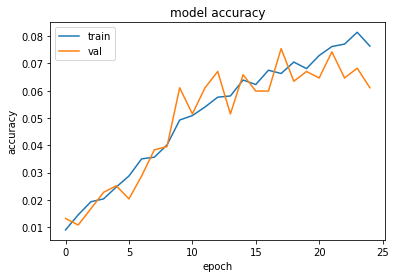

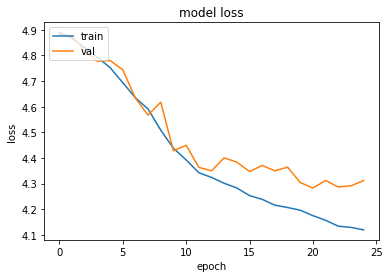

In [12]:
epochs = 25

start = time()

train_datagen_augmentation = ImageDataGenerator(
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2, 
                horizontal_flip = True)

train_datagen_augmentation.fit(train_tensors)

batch_size = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)


history = model.fit_generator(train_datagen_augmentation.flow(train_tensors, train_targets, batch_size=batch_size),  
            steps_per_epoch=train_tensors.shape[0] // batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=[checkpointer],
            validation_data=(valid_tensors, valid_targets)
            )
              
end = time()
total_time = end - start
print("The total computation time is {} ".format(total_time/60), " minutes")

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [14]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 7.0574%


In [15]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [16]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [17]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 410us/step - loss: 12.0373 - acc: 0.1383 - val_loss: 10.6138 - val_acc: 0.2527

Epoch 00001: val_loss improved from inf to 10.61376, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 2s 285us/step - loss: 10.0652 - acc: 0.2942 - val_loss: 9.9514 - val_acc: 0.2946

Epoch 00002: val_loss improved from 10.61376 to 9.95138, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 2s 260us/step - loss: 9.5697 - acc: 0.3506 - val_loss: 9.6716 - val_acc: 0.3257

Epoch 00003: val_loss improved from 9.95138 to 9.67160, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 2s 265us/step - loss: 9.3159 - acc: 0.3778 - val_loss: 9.5188 - val_acc: 0.3473

Epoch 00004: val_loss improved from 9.67160 to 9.51881, saving model to saved

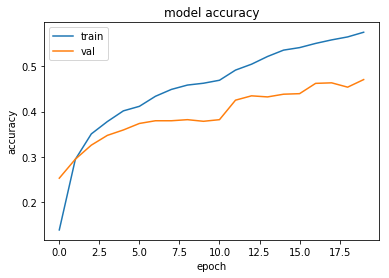

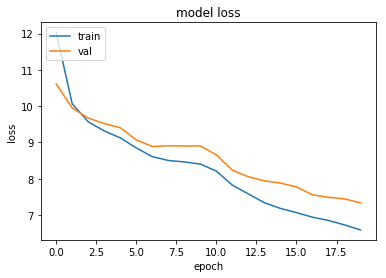

In [18]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

history = VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [20]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 47.0096%


In [21]:
import os
import zipfile
import tarfile
import requests

def download_file(url, path='./'):
    filename = url.split('/')[-1]
    print('Downloading {}'.format(filename))
    path = os.path.join(path, filename)
    r = requests.get(url, stream=True)
    with open(path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    print('Download complete')
    return filename

def extract(archive, folder):
    print('Extracting {}'.format(archive))
    
    if (archive.endswith('tgz')):
        tar = tarfile.open(archive, 'r:gz')
        tar.extractall()
        tar.close()
    elif (archive.endswith('zip')):    
        with zipfile.ZipFile(archive, 'r') as zip_ref:
            zip_ref.extractall()
    else:
        print('Archive type {} not recognized'.format(archive))

    if os.path.isdir(folder):
        print('Extracting complete'.format(archive))
    else:
        print('Extracting failed'.format(archive))
        
def download_extract(url, folder, force_download=False):
    filename = url.split('/')[-1]
    downloadPath = os.path.join(os.getcwd(), folder)
    if os.path.isdir(downloadPath) is False:
        if os.path.exists(filename):
            if force_download is False:
                print('File {} found skipping download'.format(filename))
            else:
                print('Forcing download of {}'.format(filename))
                download_file(url)
            extract(filename, downloadPath)
        else:
            download_file(url)
            extract(filename, downloadPath)


In [22]:
"""
bottleneckFeaturesXceptionUrl = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz"
bottleneckFeaturesFolder = "bottleneck_features"
download_file(bottleneckFeaturesXceptionUrl, bottleneckFeaturesFolder)
"""

'\nbottleneckFeaturesXceptionUrl = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz"\nbottleneckFeaturesFolder = "bottleneck_features"\ndownload_file(bottleneckFeaturesXceptionUrl, bottleneckFeaturesFolder)\n'

In [23]:
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [24]:
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization

Xception_model = Sequential()
BatchNormalization(axis=-1)
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:] ))

Xception_model.add(Dropout(0.4))

Xception_model.add(Dense(64, activation="relu"))

Xception_model.add(Dropout(0.3))

Xception_model.add(Dense(133, activation="softmax"))

Xception_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               8645      
Total params: 139,781
Trainable params: 139,781
Non-trainable params: 0
_________________________________________________________________


In [25]:
Xception_model.compile(loss="categorical_crossentropy",
            optimizer="rmsprop",
             metrics=["accuracy"])

Train on 6680 samples, validate on 835 samples
Epoch 1/25
6680/6680 [==============================] - 4s 604us/step - loss: 2.9312 - acc: 0.3813 - val_loss: 1.0915 - val_acc: 0.7341

Epoch 00001: val_loss improved from inf to 1.09148, saving model to saved_models/weights.best.Xception.hdf5
Epoch 2/25
6680/6680 [==============================] - 3s 384us/step - loss: 1.2285 - acc: 0.6669 - val_loss: 0.6755 - val_acc: 0.8012

Epoch 00002: val_loss improved from 1.09148 to 0.67553, saving model to saved_models/weights.best.Xception.hdf5
Epoch 3/25
6680/6680 [==============================] - 3s 380us/step - loss: 0.8962 - acc: 0.7353 - val_loss: 0.5702 - val_acc: 0.8168

Epoch 00003: val_loss improved from 0.67553 to 0.57020, saving model to saved_models/weights.best.Xception.hdf5
Epoch 4/25
6680/6680 [==============================] - 3s 378us/step - loss: 0.7555 - acc: 0.7759 - val_loss: 0.5414 - val_acc: 0.8299

Epoch 00004: val_loss improved from 0.57020 to 0.54136, saving model to s

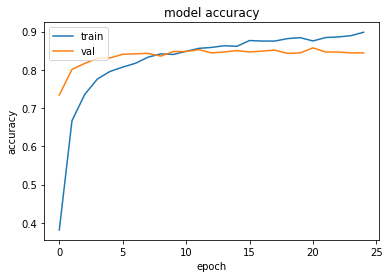

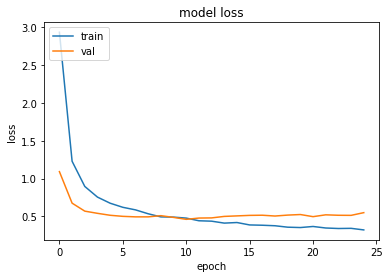

In [26]:
from keras.callbacks import ModelCheckpoint  
from keras.preprocessing.image import ImageDataGenerator

train_datagen_augmentation_2 = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.1, 
                horizontal_flip = True)

train_datagen_augmentation_2.fit(train_tensors)

epochs=25

batch_size=65

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

history = Xception_model.fit(train_Xception, train_targets,
                validation_data=(valid_Xception, valid_targets),
                epochs=epochs,
                   callbacks=[checkpointer],
                   verbose=1
                  )

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
Xception_model.load_weights("saved_models/weights.best.Xception.hdf5")

In [28]:
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

test_accuracy = 100 * np.sum(np.array(Xception_predictions) == np.argmax(test_targets, axis=1)) / len(Xception_predictions)

print("Xception Test accuracy: %.4f%%" % test_accuracy)

Xception Test accuracy: 83.3732%
